# Focused Ion Beam Scanning Electron Microscopy Image Segmentation


**Summary:**
1. SimpleITK supports a large number of filters that facilitate classical segmentation algorithms (variety of thresholding algorithms, watersheds...).
2. Once your data is segmented SimpleITK enables you to efficiently post process the segmentation (e.g. label distinct objects, analyze object shapes).

This notebook will illustrate the use of SimpleITK for segmentation of bacteria from a 3D Focused Ion Beam Scanning Electron Microscopy (FIB-SEM) image. The specific bacterium is <a href="https://en.wikipedia.org/wiki/Bacillus_subtilis">bacillus subtilis</a>, a rod shaped organism naturally found in soil and plants. The bacteria have been subjected to stress to initiate the process of forming an endospore. These endospores can be seen as a generally dark ellipsoid inside the individual bacterium. 

Data provided courtesy of the Laboratory of Cell Biology, Center for Cancer Research, National Cancer Institute, National Institutes of Health.

In [1]:
# %matplotlib notebook
%matplotlib widget

import os, glob

import SimpleITK as sitk
import pandas as pd


import matplotlib.pyplot as plt
import gui
from math import ceil

from utils import base_dir, voxel_size

# %run update_path_to_download_script
# from downloaddata import fetch_data as fdata

## Load data

Load the 3D volume and display it.

In [2]:
test_otsu_in_2D = False

#img = sitk.ReadImage(fdata("fib_sem_bacillus_subtilis.mha"))


# Read labels
img_dir = os.path.join(base_dir, "Reconstrut-980");
fname_set = sorted(
    [
        os.path.join(img_dir, fname)
        for fname in os.listdir(img_dir)
        if fname.endswith(".tiff")
    ]
);

reader = sitk.ImageSeriesReader()

if test_otsu_in_2D:
    reader.SetFileNames([fname_set[4]]) # When testing otsu in 2D
else:
    reader.SetFileNames(fname_set)

    
img = reader.Execute()

img.SetSpacing(voxel_size)


# img = sitk.ReadImage("C:/Users/snn23kfl/CIL-Demos/demos/1_Introduction/exercises/recon_new.mha")

In [3]:
if not os.path.exists(os.path.join(base_dir, "segmentation")):
    os.mkdir(os.path.join(base_dir, "segmentation"))                      

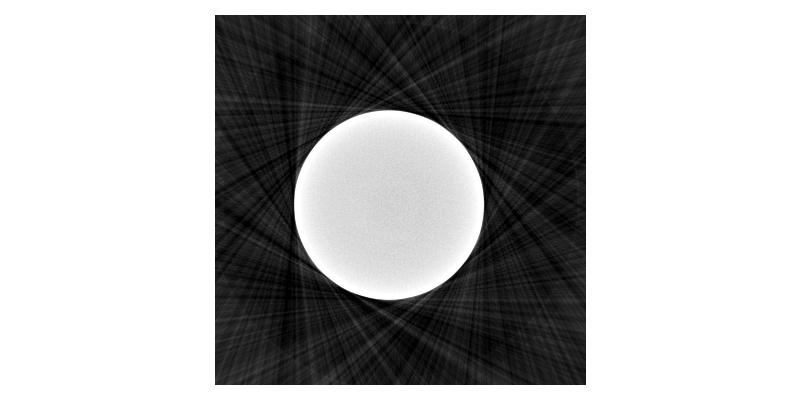

In [4]:
min_max_image_filter = sitk.MinimumMaximumImageFilter()
min_max_image_filter.Execute(img)

min_val = min_max_image_filter.GetMinimum()
max_val = min_max_image_filter.GetMaximum()

cast_image_filter = sitk.CastImageFilter()
cast_image_filter.SetOutputPixelType(sitk.sitkUInt16)
image_uint16 = cast_image_filter.Execute(60000 * (img - min_val) / (max_val - min_val))

cast_image_filter.SetOutputPixelType(sitk.sitkUInt8)
image_uint8 = cast_image_filter.Execute(255 * (img - min_val) / (max_val - min_val))
sitk.WriteImage(image_uint8, os.path.join(base_dir, "segmentation", "image_uint8.mha"), useCompression=True)

gui.MultiImageDisplay(image_list=[image_uint16], figure_size=(8, 4));

## Segmentation

To allow us to analyze the shape of whole bacteria we first need to segment them. We will do this in several steps:
1. Separate the bacteria from the embedding resin background.
2. Mark each potential bacterium with a unique label, to evaluate the segmentation.
3. Remove small components and fill small holes using binary morphology operators (opening and closing).
4. Use seed based watersheds to perform final segmentation.
5. Remove bacterium that are connected to the image boundary.

### Separate the bacteria from the background

Based on the visualization of the data above, it intuitively appears that the background and foreground are separable using a single intensity threshold. Our first step towards validating this observation is to plot the intensity distribution.

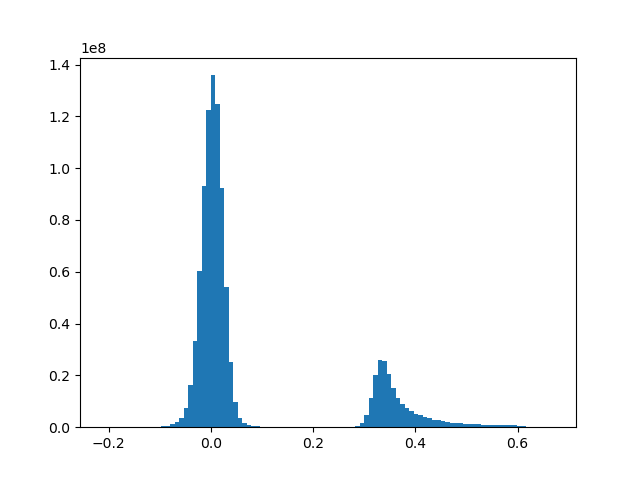

In [5]:
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img).flatten(), bins=100)
plt.show()

The histogram is bi-modal with a clear separation, which we have manually identified as having an intensity value of 120.

We can also use one of several binary threshold selection filters available in SimpleITK. 

In [6]:
# denoising_filter = sitk.GradientAnisotropicDiffusionImageFilter()
# denoising_filter.SetNumberOfIterations(5)
# denoised_img = denoising_filter.Execute(image_uint16)

# segment cylinder

In [7]:
thresh_filter = sitk.OtsuThresholdImageFilter()
thresh_filter.SetInsideValue(0)
thresh_filter.SetOutsideValue(1)
cylinder_img = thresh_filter.Execute(image_uint16)
thresh_value = thresh_filter.GetThreshold()

print("Threshold used: " + str(thresh_value))

Threshold used: 27189.0


In [8]:
file_name = "cylinder-980.mha"
sitk.WriteImage(cylinder_img, os.path.join(base_dir, "segmentation", file_name), useCompression=True)

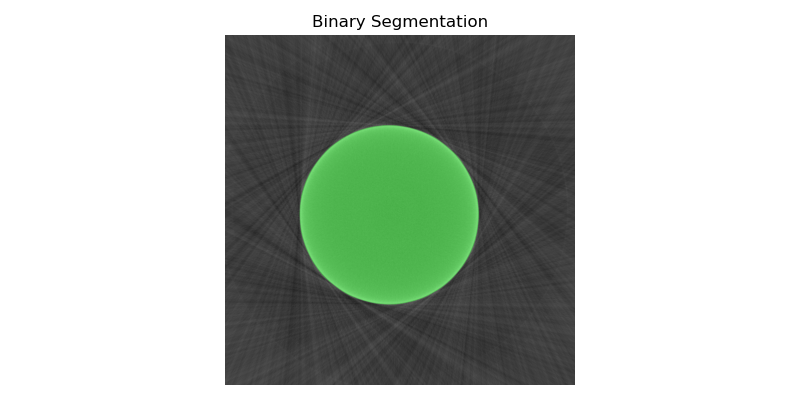

In [9]:
gui.MultiImageDisplay(
    image_list=[sitk.LabelOverlay(image_uint8, cylinder_img)],
    title_list=["Binary Segmentation"],
    figure_size=(8, 4),
);

# Segment porosity

In [10]:
thresh_filter = sitk.BinaryThresholdImageFilter   ()
thresh_filter.SetInsideValue (1)
thresh_filter.SetOutsideValue (0)
#thresh_filter.SetUpperThreshold(60000) 
thresh_filter.SetUpperThreshold(26720+2000) 
#thresh_filter.SetUpperThreshold(26720+4000) # this value i used for the full reconsreucted data

thresh_filter.SetLowerThreshold(10782+1000) # 10782 & 26720 were thresholds provided by the Otsu method on Slice 68
#thresh_filter.SetLowerThreshold(6000)
thresh_img = thresh_filter.Execute(image_uint16)

file_name = "thresh_img.mha"
sitk.WriteImage(thresh_img, os.path.join(base_dir, "segmentation", file_name), useCompression=True)

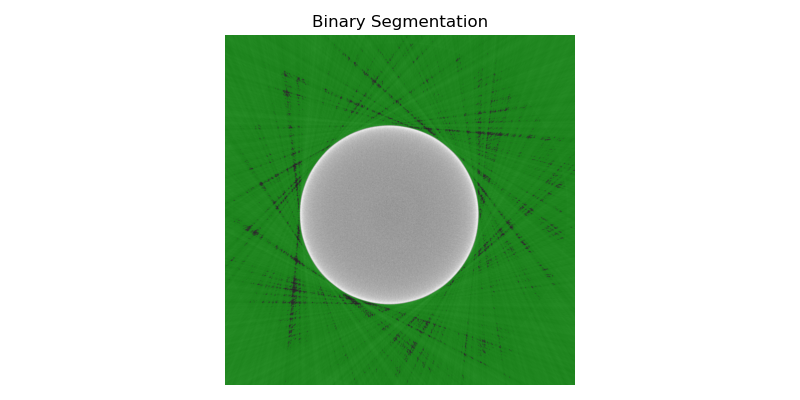

In [11]:
gui.MultiImageDisplay(
    image_list=[sitk.LabelOverlay(image_uint8, thresh_img)],
    title_list=["Binary Segmentation"],
    figure_size=(8, 4),
);

## Remove small islands and holes

Using binary morphological operations we remove small objects using the opening operation and fill small holes using the closing operation. The use of opening and closing by reconstruction maintains the boundary of the original objects.


In [12]:
cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(thresh_img, [1, 1, 1])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [1, 1, 1])

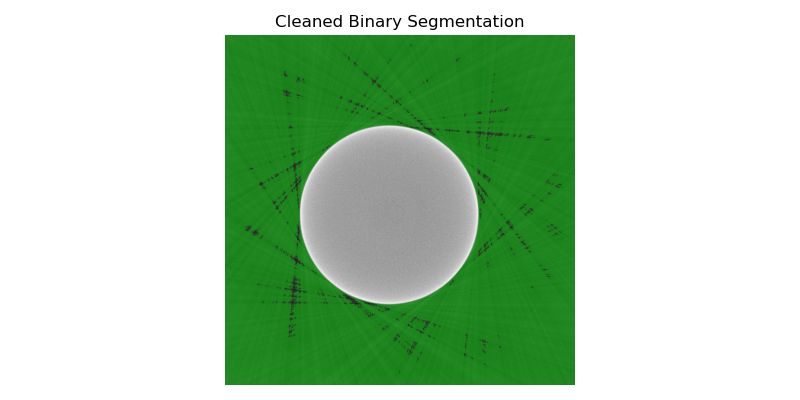

In [13]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(image_uint8, cleaned_thresh_img)],                   
                      title_list = ['Cleaned Binary Segmentation'], figure_size=(8,4));

## Mark each potential bacterium with unique label and evaluate

In [14]:
porosity_img = cleaned_thresh_img==1
label_img = sitk.ConnectedComponent(porosity_img)
porosity_img = label_img > 1

file_name = "porosity-980.mha"
sitk.WriteImage(porosity_img, os.path.join(base_dir, "segmentation", file_name), useCompression=True)

In [15]:
segmentation = cylinder_img == 1
segmentation[porosity_img == 1] = 2

file_name = "Segment-980.mha"
sitk.WriteImage(segmentation, os.path.join(base_dir, "segmentation", file_name), useCompression=True)

In [16]:
label_img = sitk.ConnectedComponent(porosity_img)
stats = sitk.LabelShapeStatisticsImageFilter()

stats.Execute(sitk.ConnectedComponent(label_img))

# Look at the distribution of sizes of connected components (bacteria).
label_sizes = [stats.GetNumberOfPixels(l) for l in stats.GetLabels()]

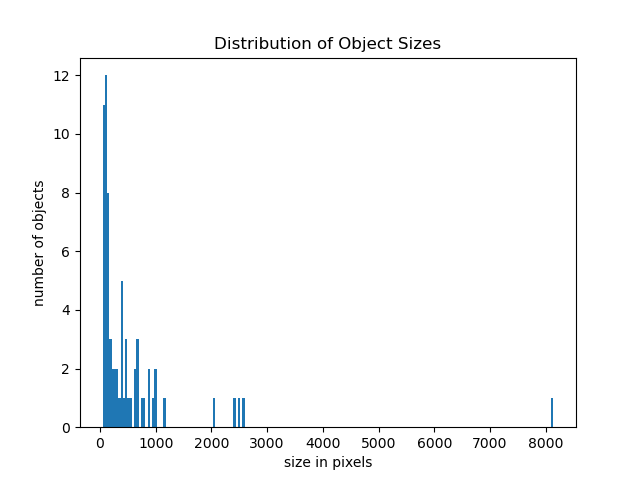

In [17]:
plt.figure()
plt.hist(label_sizes, bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()

After the morphological operations, our binary image seems to have a reasonable number of objects, but is this true? We next look at the unique objects defined by this binary segmentation (each object is marked with a unique color).

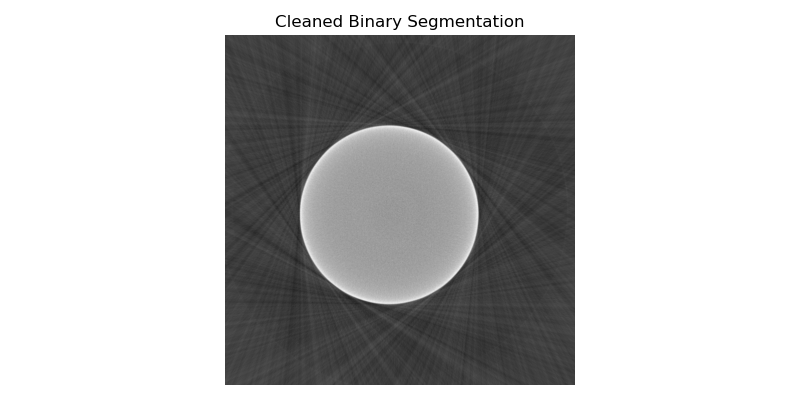

In [18]:
gui.MultiImageDisplay(
    image_list=[sitk.LabelOverlay(image_uint8, label_img)],
    title_list=["Cleaned Binary Segmentation"],
    figure_size=(8, 4),
);

## Object Analysis

Once we have the segmented objects we look at their shapes and the intensity distributions inside the objects.

Note that sizes are in nanometers. ITK and consequently SimpleITK are agnostic of the actual measurement units. It is up to you as the developer to explicitly use the correct units and more importantly, <a href="https://en.wikipedia.org/wiki/Mars_Climate_Orbiter">DO NOT MIX UNITS</a>.

We first compute all of the measurements we are interested in.

In [19]:
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(label_img)

intensity_stats = sitk.LabelIntensityStatisticsImageFilter()
intensity_stats.Execute(label_img, img)

Insert the values into a pandas dataframe and display some descriptive statistics.

In [20]:
stats_list = [
    (
        shape_stats.GetPhysicalSize(i),
        shape_stats.GetElongation(i),
        shape_stats.GetFlatness(i),
        shape_stats.GetOrientedBoundingBoxSize(i)[0],
        shape_stats.GetOrientedBoundingBoxSize(i)[2],
        intensity_stats.GetMean(i),
        intensity_stats.GetStandardDeviation(i),
        intensity_stats.GetSkewness(i),
    )
    for i in shape_stats.GetLabels()
]
cols = [
    "Volume (nm^3)",
    "Elongation",
    "Flatness",
    "Oriented Bounding Box Minimum Size(nm)",
    "Oriented Bounding Box Maximum Size(nm)",
    "Intensity Mean",
    "Intensity Standard Deviation",
    "Intensity Skewness",
]

# Create the pandas data frame and display descriptive statistics.
stats = pd.DataFrame(data=stats_list, index=shape_stats.GetLabels(), columns=cols)

In [21]:
stats

,Volume (nm^3),Elongation,Flatness,Oriented Bounding Box Minimum Size(nm),Oriented Bounding Box Maximum Size(nm),Intensity Mean,Intensity Standard Deviation,Intensity Skewness
1,0.000145,1.180924,4.531174,0.033763,0.141751,-0.033294,0.004180,0.590920
2,0.000080,1.727242,2.594858,0.034873,0.121218,-0.032987,0.004377,0.626351
3,0.000142,1.160656,5.736082,0.032105,0.169850,-0.033604,0.003718,0.615111
4,0.000067,2.064595,1.855411,0.033542,0.120631,-0.033274,0.004127,0.469693
5,0.000049,1.720334,1.419775,0.048415,0.085732,-0.034628,0.002834,0.216269
...,...,...,...,...,...,...,...,...
66,0.000086,1.122921,4.302985,0.021459,0.116585,-0.033522,0.004253,1.240860
67,0.000047,1.864283,3.105209,0.023028,0.111454,-0.033740,0.004246,1.058506
68,0.000057,2.391420,3.234899,0.023220,0.134373,-0.034584,0.002852,0.638583
69,0.000220,5.240095,5.916392,0.024471,0.405937,-0.034419,0.003132,0.601440


In [22]:
stats.describe()

,Volume (nm^3),Elongation,Flatness,Oriented Bounding Box Minimum Size(nm),Oriented Bounding Box Maximum Size(nm),Intensity Mean,Intensity Standard Deviation,Intensity Skewness
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,0.000553,1.465402,2.230929,0.078165,0.147929,0.095613,0.009766,0.095893
std,0.001076,0.700198,1.689828,0.048409,0.075607,0.109593,0.005473,0.625556
min,0.000045,1.008906,1.013197,0.021459,0.071216,-0.034956,0.002834,-1.186369
25%,0.000108,1.063779,1.061705,0.033951,0.103676,-0.033367,0.004201,-0.398630
50%,0.000224,1.158399,1.160332,0.068234,0.125538,0.179470,0.010574,-0.199187
75%,0.000612,1.689116,3.049654,0.108339,0.167779,0.188665,0.014729,0.697781
max,0.008131,5.240095,6.970780,0.251129,0.444719,0.201467,0.020381,1.240860


Create a plot to investigate the relationship, possible correlations, between volume and object shape characteristics (elongation, flatness, principal moments). 

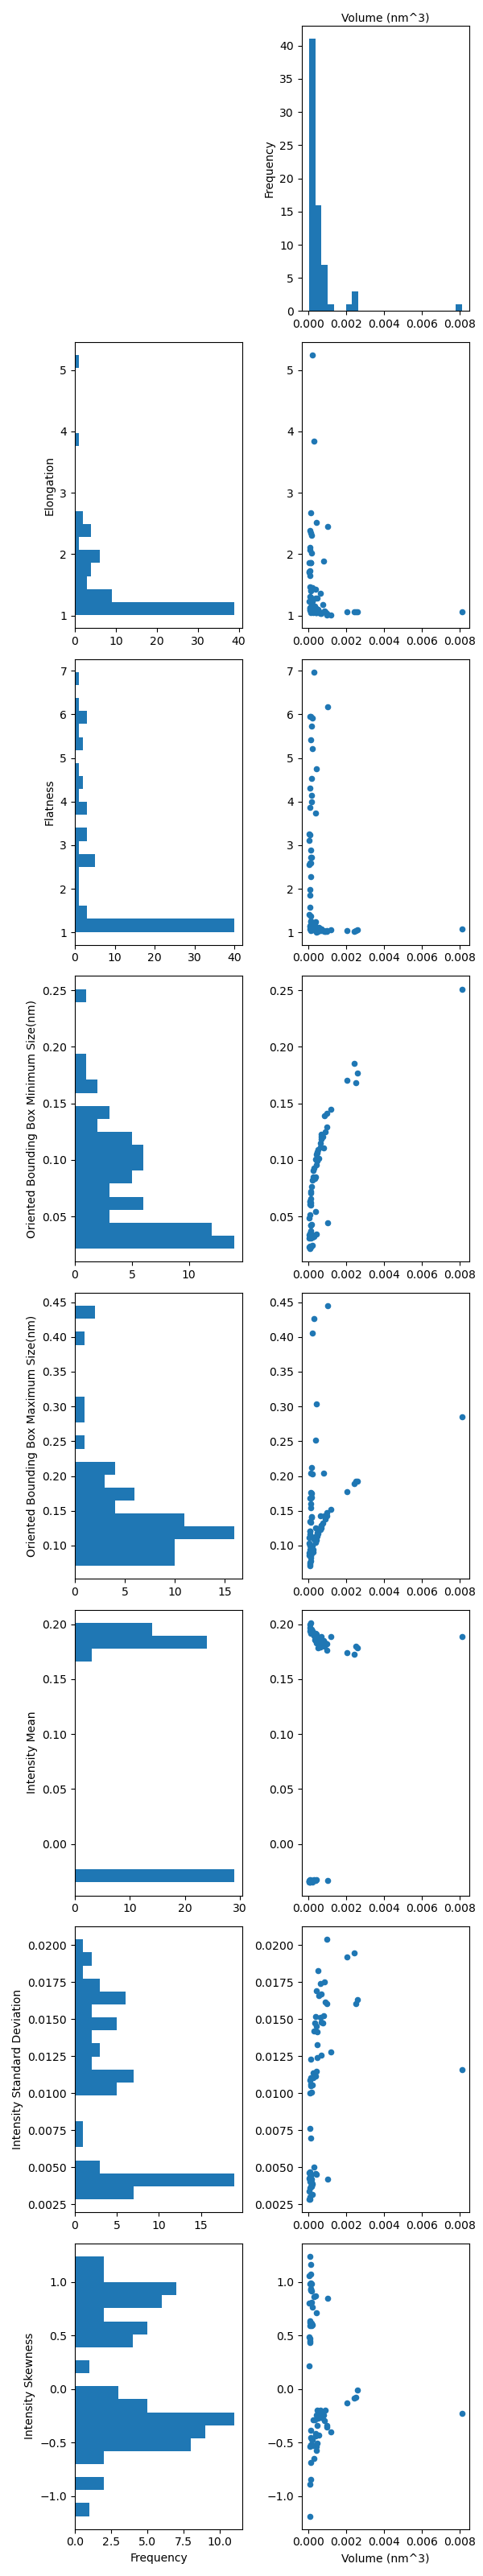

In [23]:
fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(6, 4 * len(cols)))
axes[0, 0].axis("off")

stats.loc[:, cols[0]].plot.hist(ax=axes[0, 1], bins=25)
axes[0, 1].set_xlabel(cols[0])
axes[0, 1].xaxis.set_label_position("top")

for i in range(1, len(cols)):
    c = cols[i]
    bar = stats.loc[:, [c]].plot.hist(
        ax=axes[i, 0], bins=20, orientation="horizontal", legend=False
    )
    bar.set_ylabel(stats.loc[:, [c]].columns.values[0])
    scatter = stats.plot.scatter(ax=axes[i, 1], y=c, x=cols[0])
    scatter.set_ylabel("")
    # Remove axis labels from all plots except the last (they all share the labels)
    if i < len(cols) - 1:
        bar.set_xlabel("")
        scatter.set_xlabel("")
# Adjust the spacing between plot columns and set the plots to have a tight
# layout inside the figure.
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()